# Evaluate Models on Puzzles

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xmaster6y/lczerolens/blob/main/docs/source/notebooks/features/evaluate_models_on_puzzles.ipynb)

## Setup

In [1]:
DEV = False

In [ ]:
if DEV:
    !rm -r lczerolens
    !git clone https://github.com/Xmaster6y/lczerolens -b <branch>
    !pip install -q ./lczerolens
else:
    !pip install -q lczerolens

In [ ]:
!gdown 1cxC8_8vw7akfPyc9cZxwaAbLG2Zl4XiT -O lc0-10-4238.onnx
!gdown 15__7FHvIR5-JbJvDg2eGUhIPZpkYyM7X -O lc0-19-1876.onnx
!gdown 1CvMyX3KuYxCJUKz9kOb9VX8zIkfISALd -O lc0-19-4508.onnx
!gdown 1TI429e9mr2de7LjHp2IIl7ouMoUaDjjZ -O maia-1100.onnx
!gdown 1-8IJ5WYMPpcxOsHfIKY8xKskwk2z_yrY -O maia-1900.onnx

## Load a Model

Load a leela network from file (already converted to `onnx`):

In [4]:
from lczerolens import LczeroModel

strong_model = LczeroModel.from_path(
    "lc0-19-4508.onnx"
).to("cuda")
weak_model = LczeroModel.from_path(
    "lc0-19-1876.onnx"
).to("cuda")

## Import a Puzzle Dataset

In [5]:
from datasets import load_dataset

dataset = load_dataset("lczerolens/lichess-puzzles", split="train")
dataset

Generating train split:   0%|          | 0/3974488 [00:00<?, ? examples/s]

Dataset({
    features: ['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'Themes', 'GameUrl', 'OpeningTags'],
    num_rows: 3974488
})

In [6]:
dataset.select_columns(["Rating","RatingDeviation"])[:10]

{'Rating': [1913, 1429, 1419, 1112, 1556, 1311, 1428, 1590, 1501, 1941],
 'RatingDeviation': [75, 73, 75, 74, 81, 75, 79, 75, 75, 85]}

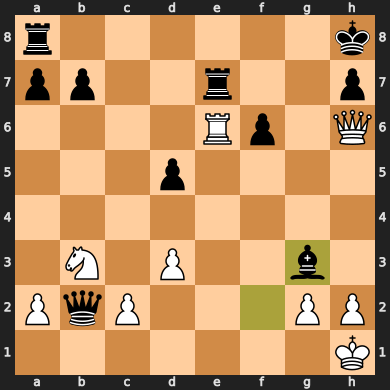

In [7]:
from lczerolens.play import Puzzle

puzzle = Puzzle.from_dict(dataset[0])
puzzle

## Evaluate a Sampler on a Puzzle

In [8]:
from lczerolens.play import PolicySampler, RandomSampler

strong_sampler = PolicySampler(strong_model)
weak_sampler = PolicySampler(weak_model)
random_sampler = RandomSampler()

s_res = puzzle.evaluate(strong_sampler)
w_res = puzzle.evaluate(weak_sampler)
r_res = puzzle.evaluate(random_sampler)
print(f"Strong: {s_res}\nWeak: {w_res}\nRandom: {r_res}")

Strong: {'score': 1.0, 'perplexity': 1.2404212481769572, 'normalized_perplexity': 0.2012938831392448}
Weak: {'score': 0.0, 'perplexity': 3.014065429213698, 'normalized_perplexity': 0.48911846292045047}
Random: {'score': 0.0, 'perplexity': 6.162240059750529, 'normalized_perplexity': 0.9999999857197207}


Two puzzle failure modes to distinguish:
- Some are failed due to the existance of an alternative solution.
- Interestingly some puzzles can be failed by "better" models, due to catstorphic forgetting on OOD boards (w.r.t. high level).

In general, the perplexity is a better indicator of performance than the success rate.

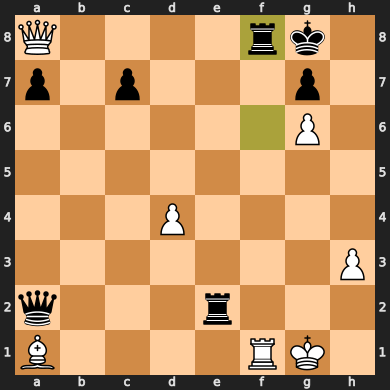

Strong: {'score': 0.0, 'perplexity': 2.389747450234118, 'normalized_perplexity': 0.08240508449083166}
Weak: {'score': 0.0, 'perplexity': 6.06274610278349, 'normalized_perplexity': 0.20906021044081}
Random: {'score': 0.0, 'perplexity': 29.00000010803342, 'normalized_perplexity': 1.0000000037252903}


In [9]:
p_alt = Puzzle.from_dict(dataset[140])
display(p_alt)

s_res = p_alt.evaluate(strong_sampler)
w_res = p_alt.evaluate(weak_sampler)
r_res = p_alt.evaluate(random_sampler)
print(f"Strong: {s_res}\nWeak: {w_res}\nRandom: {r_res}")

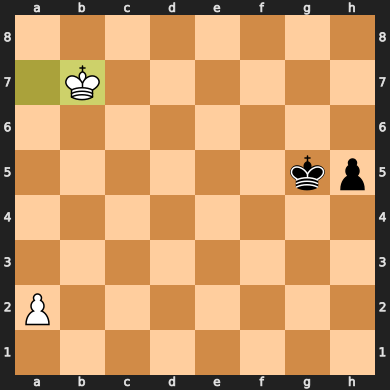

Strong: {'score': 0.0, 'perplexity': 9.04959981101378, 'normalized_perplexity': 0.992495261574585}
Weak: {'score': 0.5, 'perplexity': 2.4823822585127777, 'normalized_perplexity': 0.2722498983869152}
Random: {'score': 0.25, 'perplexity': 9.118028142900856, 'normalized_perplexity': 0.9999999906867744}


In [10]:
p_fail = Puzzle.from_dict(dataset[1966])
display(p_fail)

s_res = p_fail.evaluate(strong_sampler)
w_res = p_fail.evaluate(weak_sampler)
r_res = p_fail.evaluate(random_sampler)
print(f"Strong: {s_res}\nWeak: {w_res}\nRandom: {r_res}")

## Scale Evaluation

In [11]:
def puzzle_generator(dataset, lim=10_000):
    i = 0
    for d in dataset:
        i += 1
        if i > lim:
            break
        yield Puzzle.from_dict(d)

In [12]:
res_gen = Puzzle.evaluate_multiple(puzzle_generator(dataset), strong_sampler, batch_size=40_000)

In [13]:
res_list = list(res_gen)
res_list[:10]

[{'score': 1.0,
  'perplexity': 1.2404205826705745,
  'normalized_perplexity': 0.20129377514176872},
 {'score': 1.0,
  'perplexity': 1.3744659351664095,
  'normalized_perplexity': 0.1691850612599362},
 {'score': 0.5,
  'perplexity': 2.1135576136768535,
  'normalized_perplexity': 0.13642955731700573},
 {'score': 0.5,
  'perplexity': 1.7012988651684864,
  'normalized_perplexity': 0.06854728471115429},
 {'score': 0.6666666666666666,
  'perplexity': 3.240762127514147,
  'normalized_perplexity': 0.5179149651380368},
 {'score': 1.0,
  'perplexity': 1.5857003537430583,
  'normalized_perplexity': 0.05984840311927422},
 {'score': 0.5,
  'perplexity': 2.68709476229894,
  'normalized_perplexity': 0.07395984916879911},
 {'score': 0.5,
  'perplexity': 1.6815355869452686,
  'normalized_perplexity': 0.03878172640920447},
 {'score': 1.0,
  'perplexity': 1.1851564440638345,
  'normalized_perplexity': 0.16127936407376375},
 {'score': 0.0,
  'perplexity': 14.947910753535837,
  'normalized_perplexity': 0.

## Plot the Results

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def make_df(res):
    records = []
    columns = None
    for idx, (m, puzzle) in enumerate(zip(res, puzzle_generator(dataset))):
        p_dict = puzzle.__dict__
        if m["score"] == 0:
            result = "fail"
        elif m["score"] == 1:
            result = "success"
        else:
            result = "partial"
        if columns is None:
            columns = ["idx", "result"] + [ k for k in m.keys()] + [ k for k in p_dict.keys()]
        records.append({"idx":idx, "result":result, **m, **p_dict})

    return pd.DataFrame(records, columns=columns)

PALETTE = {"fail":"red", "success":"green", "partial":"blue"}

In [15]:
strong_df = make_df(res_list)

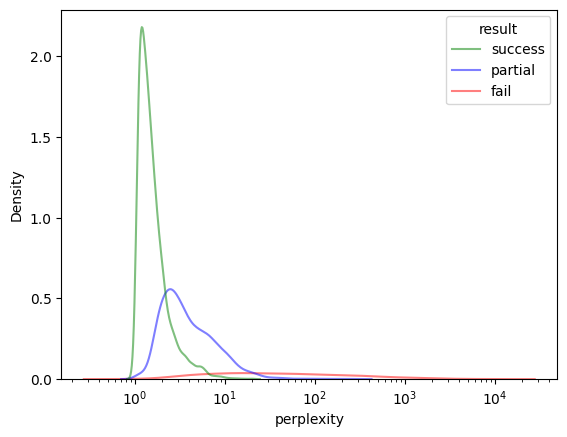

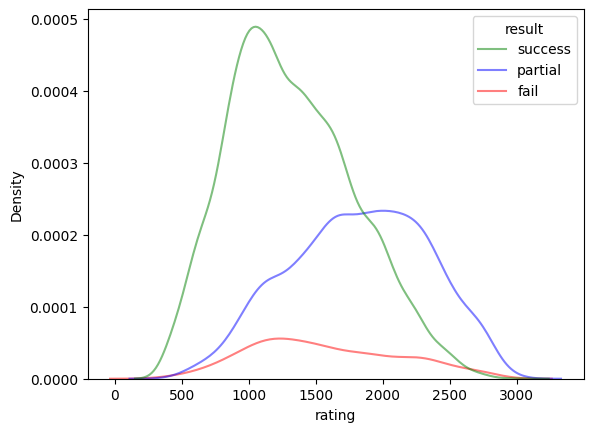

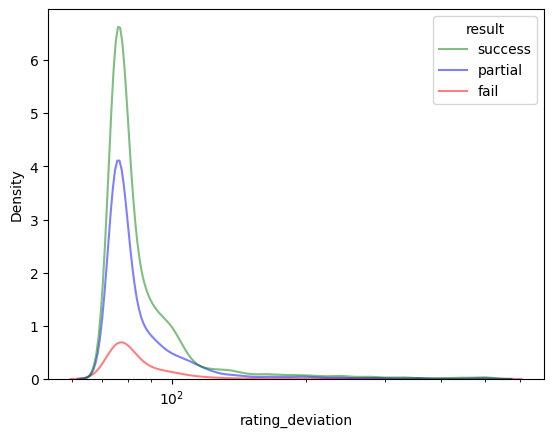

In [16]:
sns.kdeplot(strong_df, x="perplexity", hue="result", log_scale=True, alpha=0.5, palette=PALETTE, levels=20)
plt.show()
sns.kdeplot(strong_df, x="rating", hue="result", log_scale=False, alpha=0.5, palette=PALETTE, levels=20)
plt.show()
sns.kdeplot(strong_df, x="rating_deviation", hue="result", log_scale=True, alpha=0.5, palette=PALETTE, levels=20)
plt.show()

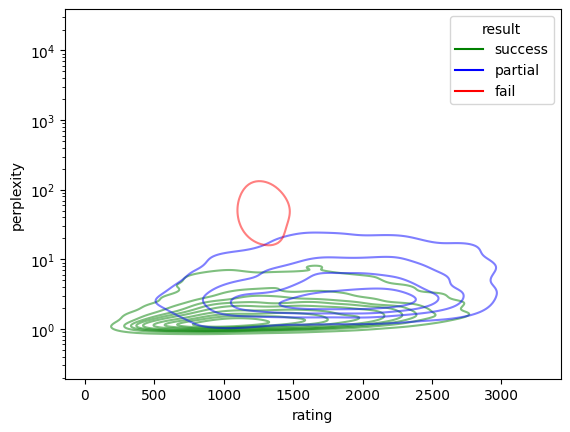

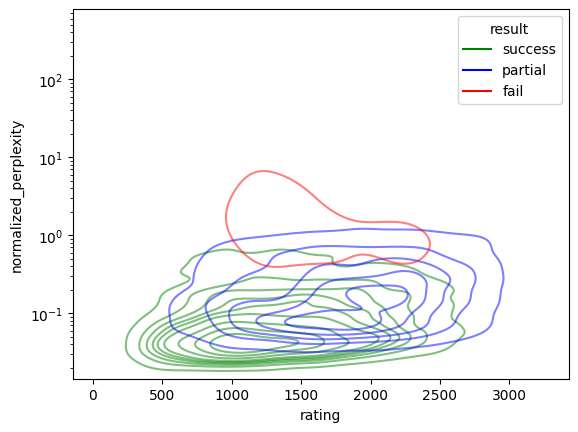

In [17]:
sns.kdeplot(strong_df, x="rating", y="perplexity", hue="result", log_scale=(False,True), alpha=0.5, palette=PALETTE, levels=10)
plt.show()
sns.kdeplot(strong_df, x="rating", y="normalized_perplexity", hue="result", log_scale=(False,True), alpha=0.5, palette=PALETTE, levels=10)
plt.show()

## Compare Models

In [18]:
weak_res_gen = Puzzle.evaluate_multiple(puzzle_generator(dataset), weak_sampler, batch_size=40_000)
weak_df = make_df(weak_res_gen)

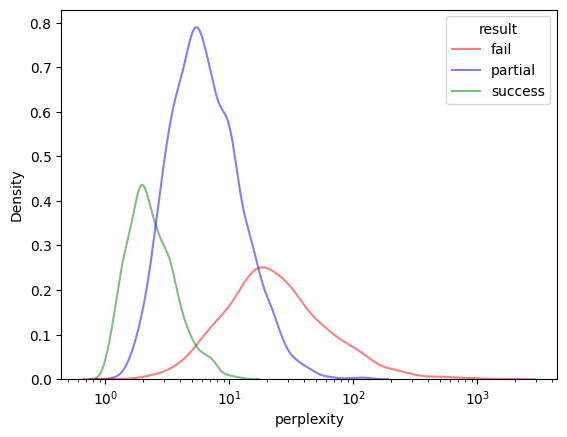

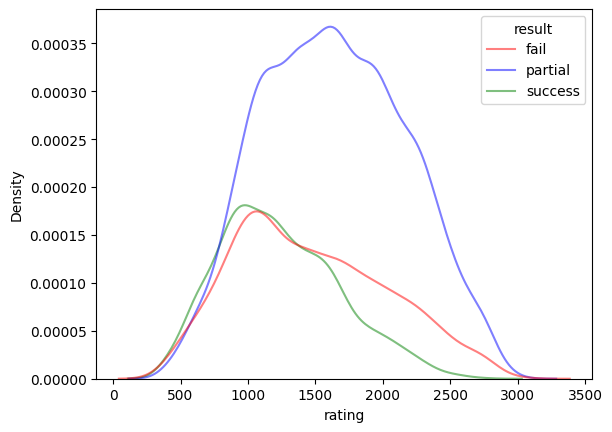

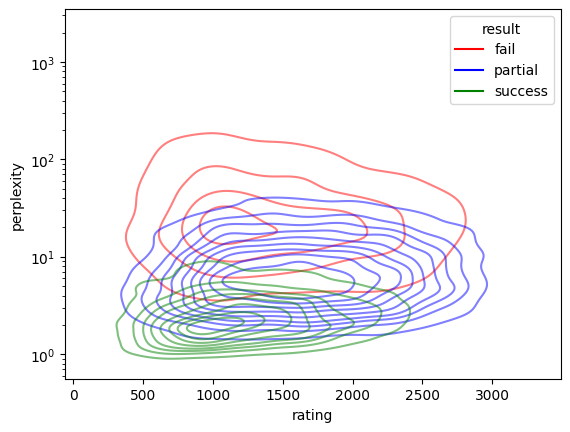

In [19]:
sns.kdeplot(weak_df, x="perplexity", hue="result", log_scale=True, alpha=0.5, palette=PALETTE)
plt.show()
sns.kdeplot(weak_df, x="rating", hue="result", log_scale=False, alpha=0.5, palette=PALETTE)
plt.show()
sns.kdeplot(weak_df, x="rating", y="perplexity", hue="result", log_scale=(False,True), alpha=0.5, palette=PALETTE, levels=10)
plt.show()

In [20]:
random_res_gen = Puzzle.evaluate_multiple(puzzle_generator(dataset), random_sampler, batch_size=40_000)
random_df = make_df(random_res_gen)

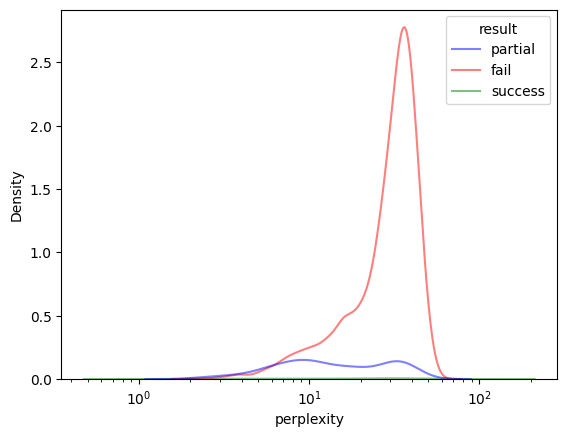

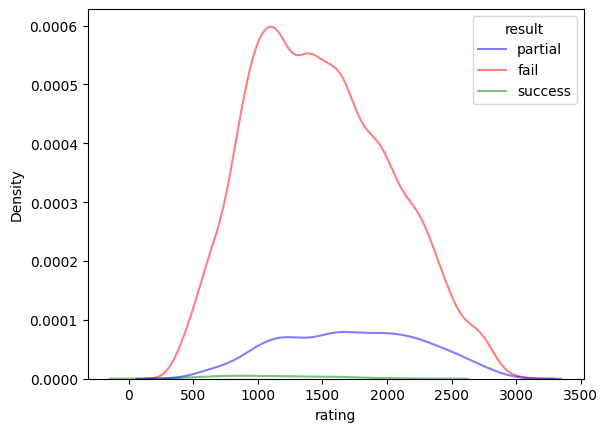

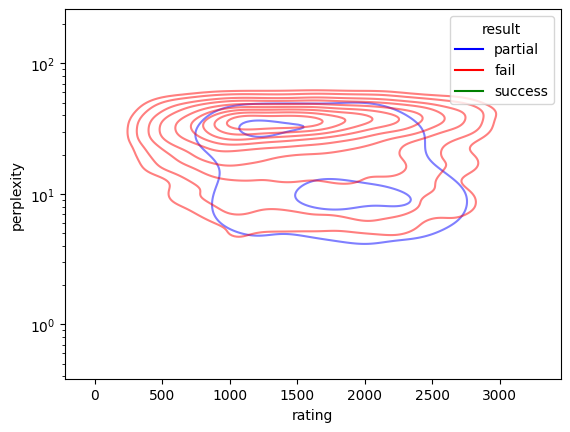

In [21]:
sns.kdeplot(random_df, x="perplexity", hue="result", log_scale=True, alpha=0.5, palette=PALETTE)
plt.show()
sns.kdeplot(random_df, x="rating", hue="result", log_scale=False, alpha=0.5, palette=PALETTE)
plt.show()
sns.kdeplot(random_df, x="rating", y="perplexity", hue="result", log_scale=(False,True), alpha=0.5, palette=PALETTE, levels=10)
plt.show()

## Explore Failures

In [22]:
easy_fails = strong_df[(strong_df["result"] == "fail") & (strong_df["rating"] < 600)]
len(easy_fails)

14

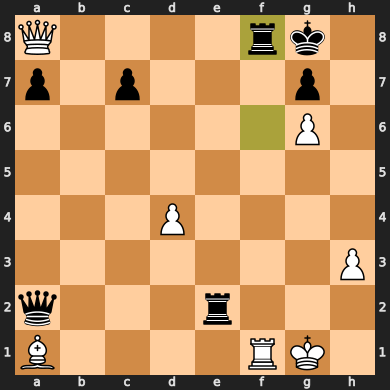

Strong: {'score': 0.0, 'perplexity': 2.389747450234118, 'normalized_perplexity': 0.08240508449083166}
Weak: {'score': 0.0, 'perplexity': 6.06274610278349, 'normalized_perplexity': 0.20906021044081}
Random: {'score': 0.0, 'perplexity': 29.00000010803342, 'normalized_perplexity': 1.0000000037252903}


In [23]:
row = easy_fails.iloc[0]
p_idx = int(row["idx"])
p = Puzzle.from_dict(dataset[p_idx])
display(p)

s_res = p.evaluate(strong_sampler)
w_res = p.evaluate(weak_sampler)
r_res = p.evaluate(random_sampler)
print(f"Strong: {s_res}\nWeak: {w_res}\nRandom: {r_res}")